In [1]:
import os, glob, cv2, shutil, joblib,gc, random, re
import tensorflow as tf
import numpy as np
import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import skimage
import random
import warnings
warnings.filterwarnings(action='ignore')
import datetime
print(datetime.datetime.today())

2022-11-25 10:47:31.714064


In [2]:
if not "label_df.csv" in os.listdir():

    df=pd.read_csv("/lustre/data/vHIT/s3/create_annotation/20221122/01_segmentation_may_be_succeeded.tsv",sep='\t')
    df.output_path=[i.replace("create_annotation","upload").replace("first.",'') for i in df.output_path]

    files=list();h_tags=list();v_tags=list()
    for sub_path in tqdm(df.output_path):
        sub_df=pd.read_csv(sub_path,sep='\t')
        if 'horizontal_tagging' in sub_df.columns:
            for frame,h_tag, v_tag in sub_df[['frame_number','horizontal_tagging','vertical_tagging']].values:
                find_file=glob.glob(f"{os.path.dirname(sub_path)}/horizontal_vertical/*_{frame}-all.avi")
                if len(find_file)==1:
                    files.append(find_file[0])
                    h_tags.append(h_tag)
                    v_tags.append(v_tag)
    label_df=pd.DataFrame({"files":files,'horizontal_tagging':h_tags,'vertical_tagging':v_tags})
    label_df.to_csv("label_df.csv",index=False)
label_df=pd.read_csv("label_df.csv")
label_df.horizontal_tagging=label_df.horizontal_tagging.fillna('mid')
label_df.vertical_tagging=label_df.vertical_tagging.fillna('mid')

In [3]:
def video_gray2rgb(df):
    out=np.zeros(df.shape[:3]+(3,),dtype='u1')
    for i in range(df.shape[0]):
        img=cv2.cvtColor(df[i,:,:,0],cv2.COLOR_GRAY2RGB)
        out[i,:,:,:]=img   
        del img
    return out
def batch_avi(data,idx,BATCH_SIZE=1024,
              font=cv2.FONT_HERSHEY_SIMPLEX):
    
    def label_vis(data,i,font):
        input_img=cv2.cvtColor(
            data[i,:,:,0],cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img=cv2.cvtColor(
            data[i,:,:,1]*255,cv2.COLOR_GRAY2RGB).astype('u1')
        pred_img[:,:,(0,2)]=0
        
        label_img=cv2.addWeighted(input_img,1,pred_img,.2,0)
        text=f"Index : {i}"
        cv2.putText(label_img,text, (80,30),font,1,(255,0,0),2)
        
        return np.expand_dims(label_img,axis=0)
    return np.concatenate(
        [label_vis(data,i, font) 
         for i in range(
             (BATCH_SIZE*idx),(np.min([data.shape[0],(idx+1)*BATCH_SIZE])))])

def write_avi(data,file_name,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    (width, height)=data.shape[1:3]
    out = cv2.VideoWriter(file_name, fourcc, fps, (height, width),isColor=True)
    for i in range(len(data)):
        out.write(data[i])
    out.release()
    
def my_confusion_matrix(y_true,y_pred,cutoff=.5):
    label_true=y_true>=.5
    pred_true=y_pred>=cutoff
    label_false= ~ label_true
    pred_false = ~ pred_true
    tp=np.sum(label_true&pred_true)
    fn=np.sum(label_true)-tp
    fp=np.sum(label_false&pred_true)
    tn=np.sum(label_false)-fp
    return tp,fn,fp,tn


def read_avi(file):
    data=list()
    cap = cv2.VideoCapture(file)
    batch=20
    cnt=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            frame=cv2.resize(frame,(320,240))
            frame=cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
            frame=np.expand_dims(frame/255, axis=0)
            data.append(frame)
            cnt+=1
            cv2.waitKey(1)
        else:
            break
        if cnt==batch:
            break
    cap.release()
    cv2.destroyAllWindows()
    out=np.concatenate(data).astype('float')
    if out.shape[0]!=batch:
        out=np.concatenate([out,np.zeros((batch-out.shape[0],240,320),dtype=np.float)],axis=0).astype('float')
    out=np.diff(out,axis=0)[:].sum(axis=0)
    out=(((out-out.min())/(out.max()-out.min()))*255).astype('u1')
    return out.copy()
print(datetime.datetime.today())

2022-11-25 10:47:49.061444


In [4]:
def my_generator(label_df):
    def generator():
        label=np.array([
            [6,7,8],[3,4,5],[0,1,2]])
        for (file,y1,y2) in label_df.values:
            x=read_avi(os.path.realpath(file))/255
            # y=label[np.where([y2==i for i in ['down','mid','up']])[0],
            #         np.where([y1==i for i in ['right','mid','left']])[0]]
            # yield x, y
            out2=np.zeros(3);out3=np.zeros(3)
            
            if y1=='left':
                out2[0]=1
            elif y1=='mid':
                out2[1]=1
            elif y1=='right':
                out2[2]=1
            
            if y2=='up':
                out3[0]=1
            elif y2=='mid':
                out3[1]=1
            elif y2=='down':
                out3[2]=1

            yield x, (out2,out3)
    return generator
print(datetime.datetime.today())

2022-11-25 10:47:51.478132


In [5]:
model=tf.keras.models.load_model('수평수직모델.h5',compile=False)
print(datetime.datetime.today())

2022-11-25 10:47:53.354738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:47:53.358728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:47:53.359044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 10:47:53.359524: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2022-11-25 10:47:54.551952


# 모델링

## 모델 확인

### Train

In [6]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320);
y_shape=(3,3);y_type=(output_type,output_type)

for K, (train_idx,test_idx) in enumerate(kf.split(label_df),1):
    
    train_files=label_df.loc[train_idx]
    test_files=label_df.loc[test_idx]
    train_files, valid_files=train_test_split(
        train_files, test_size=.2, random_state=42)
    train_files=train_files.sample(
        frac=1,random_state=42).reset_index().drop('index',axis=1)
    with tf.device("/cpu:0"):
        random.seed(42)
        tr_dataset=tf.data.Dataset.from_generator(
            my_generator(train_files),
            output_shapes=(output_shape, y_shape),
            output_types=(output_type, y_type))

        random.seed(42)
        te_dataset=tf.data.Dataset.from_generator(
            my_generator(test_files),
            output_shapes=(output_shape, y_shape),
            output_types=(output_type, y_type))
        random.seed(42)
        val_dataset=tf.data.Dataset.from_generator(
            my_generator(valid_files),
            output_shapes=(output_shape, y_shape),
            output_types=(output_type, y_type))
        tr_gen =tr_dataset.batch(256).prefetch(1)
        te_gen =te_dataset.batch(1).prefetch(1)
        val_gen=val_dataset.batch(256).prefetch(1)
    break

In [8]:
model=tf.keras.models.load_model('수평수직모델.h5',compile=False)
# model=my_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=.01),
    # loss='sparse_categorical_crossentropy',metrics='acc'
    loss={"output1":'categorical_crossentropy', 
          "output2":'categorical_crossentropy'},
    metrics={"output1":'accuracy',
             "output2":'accuracy'},
    )

callbacks=[
    tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10,
        mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',patience=5,factor=0.1,
        mode='min')
]
model.fit(tr_gen, epochs=500, validation_data=val_gen,
          verbose=1,callbacks=callbacks)


Epoch 1/500


2022-11-25 10:48:43.536715: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB (rounded to 2480013312)requested by op model_4/conv2d_81/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-25 10:48:43.536797: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-11-25 10:48:43.536822: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 80, Chunks in use: 79. 20.0KiB allocated for chunks. 19.8KiB in use in bin. 5.9KiB client-requested in use in bin.
2022-11-25 10:48:43.536831: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.0KiB allocated for chunks. 3.0KiB in use in bin. 3.0KiB client-requested in use in bin.
2022-11-25 10:48:4

KeyboardInterrupt: 

### valid

In [6]:
kf = KFold(n_splits = 3, shuffle = False)
output_type='float32';output_shape=(240,320);
y_shape=(3,3);y_type=(output_type,output_type)
dfs=list()
target_label1=np.array(['left','mid','right'])
target_label2=np.array(['up','mid','down'])

print(datetime.datetime.today())
tp_sum=dict();fn_sum=dict();fp_sum=dict();tn_sum=dict()
for K, (train_idx,test_idx) in enumerate(kf.split(label_df[::40]),1):
    
    for cutoff in np.arange(0,1.1,0.05):
        for out_type in [0,1]:
            if out_type==0:
                target_label=target_label1
            else:
                target_label=target_label2
            for target in target_label:
                cond=f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{cutoff:.02f}"
                tp_sum[cond]=0;fn_sum[cond]=0;fp_sum[cond]=0;tn_sum[cond]=0
    
    test_files=label_df.loc[test_idx]
    test_files=test_files.reset_index(drop=True)
    print(f"K = {K}, test_length : {len(test_files)}")
    
    with tf.device("/cpu:0"):
        random.seed(42)
        te_dataset=tf.data.Dataset.from_generator(
            my_generator(test_files),
            output_shapes=(output_shape, y_shape),
            output_types=(output_type, y_type))
        te_gen =te_dataset.batch(1).prefetch(1)
        
    with tf.device("/gpu:0"):
    #     ###################
    #     """
    #     모델 검증
    #     """
        for i,(x,y) in tqdm(enumerate(te_gen)):
            pred=model.predict(x)
            y1_pred,y2_pred=[np.argmax(i) for i in pred]
            test_files.loc[i,'y1_pred']=target_label1[y1_pred]
            test_files.loc[i,'y2_pred']=target_label2[y2_pred]
            for target in range(3):
                for out_type in [0,1]:
                    if out_type==0:
                        target_label=target_label1
                    else:
                        target_label=target_label2

                    y_true=y[out_type][:,target].numpy()
                    y_pred=pred[out_type][:,target].astype('float64')

                    for cutoff in np.arange(0,1.1,0.05):
                        cond=f"K_{K}_out_type_{out_type}_target_{target_label[target]}_cutoff_{cutoff:.02f}"
                        tp,fn,fp,tn=my_confusion_matrix(y_true,y_pred,cutoff)
                        # tn,fn,fp,tp=confusion_matrix(y_true,y_pred,cutoff=cutoff)
                        tp_sum[cond]+=tp;fn_sum[cond]+=fn;fp_sum[cond]+=fp;tn_sum[cond]+=tn
        dfs.append(test_files)
# pd.concat(dfs).to_csv('안진방향판별_output.csv',index=False)
print(datetime.datetime.today())

2022-11-25 10:34:40.156020
K = 1, test_length : 3948


0it [00:00, ?it/s]2022-11-25 10:34:40.676064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
3948it [02:20, 28.10it/s]


K = 2, test_length : 3947


3947it [02:20, 28.07it/s]


K = 3, test_length : 3947


3947it [02:20, 28.01it/s]

2022-11-25 10:41:42.324136


In [7]:
# joblib.dump([tp_sum,fn_sum,fp_sum,tn_sum],'수평수직지표.pkl')
from itertools import cycle
import matplotlib.pyplot as plt 
import numpy as np
import joblib
from sklearn import metrics
# tp_sum,fn_sum,fp_sum,tn_sum=joblib.load('수평수직지표.pkl')

In [8]:
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
out_type=0
target_label=target_label1
# out_type=1
# target_label=target_label2
roc_aucs=dict()
for target in target_label:
    tpr=dict();fpr=dict()
    for K in range(1,4):
        tpr[K]=list();fpr[K]=list()    
        for i in np.arange(0,1.1,.05):
            tpr[K].append(tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
                tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
                fn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
            fpr[K].append(fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
                fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
                tn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
        tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])

    for K,color in zip(range(1,4),colors):
        roc_auc=metrics.auc(fpr[K],tpr[K])
        roc_aucs[f"{target}_{K}"]=roc_auc

In [9]:
roc_aucs

{'left_1': 0.4647086251241751,
 'left_2': 0.49433533569739074,
 'left_3': 0.5017608657526956,
 'mid_1': 0.5675107489326134,
 'mid_2': 0.5242032857345742,
 'mid_3': 0.4729541277035377,
 'right_1': 0.47792212346451074,
 'right_2': 0.5285638616452424,
 'right_3': 0.5055087008270056}

In [10]:
np.mean(list(roc_aucs.values()))

0.5041630749868607

In [11]:
# with open("수평수직지표.json", 'w') as outfile:
#     json.dump(roc_aucs, outfile)

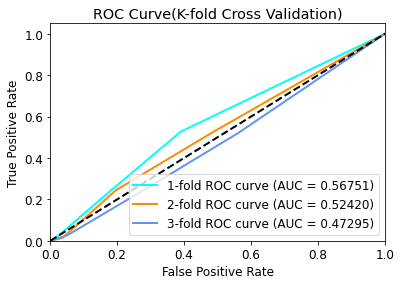

2022-11-25 10:41:42.452693


In [12]:
target="mid";out_type=0
tpr=dict();fpr=dict()
for K in range(1,4):
    tpr[K]=list();fpr[K]=list()    
    for i in np.arange(0,1.1,.05):
        tpr[K].append(tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            tp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            fn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
        fpr[K].append(fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]/(
            fp_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]+\
            tn_sum[f"K_{K}_out_type_{out_type}_target_{target}_cutoff_{i:.02f}"]))
    tpr[K]=np.array(tpr[K]);fpr[K]=np.array(fpr[K])
    
plt.figure()
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams.update({'font.size': 12})
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
lw=2
for K,color in zip(range(1,4),colors):
    roc_auc=metrics.auc(fpr[K],tpr[K])
    plt.plot(
        fpr[K],
        tpr[K],
        label=f"{K}-fold ROC curve (AUC = {roc_auc:0.5f})",
        color=color,
        lw=lw
    )
plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(K-fold Cross Validation)")
plt.legend(loc="lower right")
plt.show()
print(datetime.datetime.today())